<a href="https://colab.research.google.com/github/JulioClemente/Project_loggi/blob/main/Project_loggi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

A Loggi é uma inovadora startup brasileira focada em tecnologia logística. Fundada em 2013 com o objetivo inicial de entregar documentos, a empresa expandiu suas operações para o e-commerce em 2016 e, desde 2017, também realiza entregas de alimentos. Como outras empresas do setor, a Loggi enfrenta desafios significativos em áreas metropolitanas, onde a distribuição desigual de entregas e a complexidade geográfica das cidades aumentam as dificuldades logísticas.

Os dados utilizados nesta análise provêm do repositório Loggi Benchmark for Urban Deliveries (BUD), que inclui conjuntos de dados e scripts de benchmark para resolver problemas logísticos típicos, como otimização de rotas e alocação de entregas em veículos com capacidade limitada. Esses dados, que são uma síntese de fontes públicas como IBGE e IPEA, refletem os desafios enfrentados pela Loggi, especialmente no que diz respeito à escala de operação.

O objetivo desta análise é investigar os problemas logísticos enfrentados pelos hubs regionais da Loggi, utilizando dados específicos da região de Brasília. Buscarei obter insights sobre as rotas de entrega atuais e propor soluções para torná-las mais eficientes e ágeis. Ao explorar os dados logísticos, pretendo entender o impacto dos desafios enfrentados na eficiência das entregas e encontrar maneiras práticas de melhorá-las, contribuindo para a otimização das operações de entrega da Loggi.

Este estudo aborda não apenas os problemas logísticos atuais, mas também propõe uma abordagem prática para melhorar a eficiência dos hubs de distribuição e equilibrar a carga de trabalho entre eles. Com base nos dados analisados, espero fornecer recomendações detalhadas e viáveis que possam ser implementadas para aprimorar as operações logísticas da Loggi em Brasília e potencialmente em outras regiões atendidas pela empresa.

# Passos para a Análise Exploração e Entendimento dos Dados

## **Importação dos Dados:**
Carregar os conjuntos de dados do repositório Loggi Benchmark for Urban Deliveries (BUD) para entender a informação disponível. Análise Exploratória dos Dados (EDA): Realizar uma EDA para compreender as variáveis envolvidas, a estrutura dos dados e identificar padrões ou anomalias. Análise de Rotas e Capacidade

## **Mapeamento das Rotas:**
Identificar as rotas de entrega atuais e analisar sua eficiência. Otimização de Rotas: Utilizar algoritmos de otimização para sugerir rotas mais eficientes. Alocação de Entregas: Examinar a alocação de entregas em veículos com capacidade limitada para garantir uma distribuição balanceada. Desafios Específicos de Brasília

## **Geografia e Infraestrutura Urbana:**
Considerar as particularidades da geografia e infraestrutura urbana de Brasília que afetam a logística. Distribuição Desigual: Analisar a distribuição das entregas e propor soluções para áreas com alta demanda. Recomendações e Implementação

## **Soluções Práticas:**
Desenvolver soluções práticas e implementáveis com base na análise dos dados. Monitoramento e Ajustes: Propor métodos de monitoramento contínuo e ajustes para garantir a eficácia das soluções implementadas. Conclusão

Ao final desta análise, pretendo fornecer um conjunto de recomendações detalhadas que poderão ser aplicadas para melhorar a eficiência dos hubs de distribuição da Loggi em Brasília. A meta é não apenas resolver os desafios logísticos atuais, mas também estabelecer um modelo que possa ser replicado em outras regiões, contribuindo para a excelência operacional da Loggi em todo o Brasil.


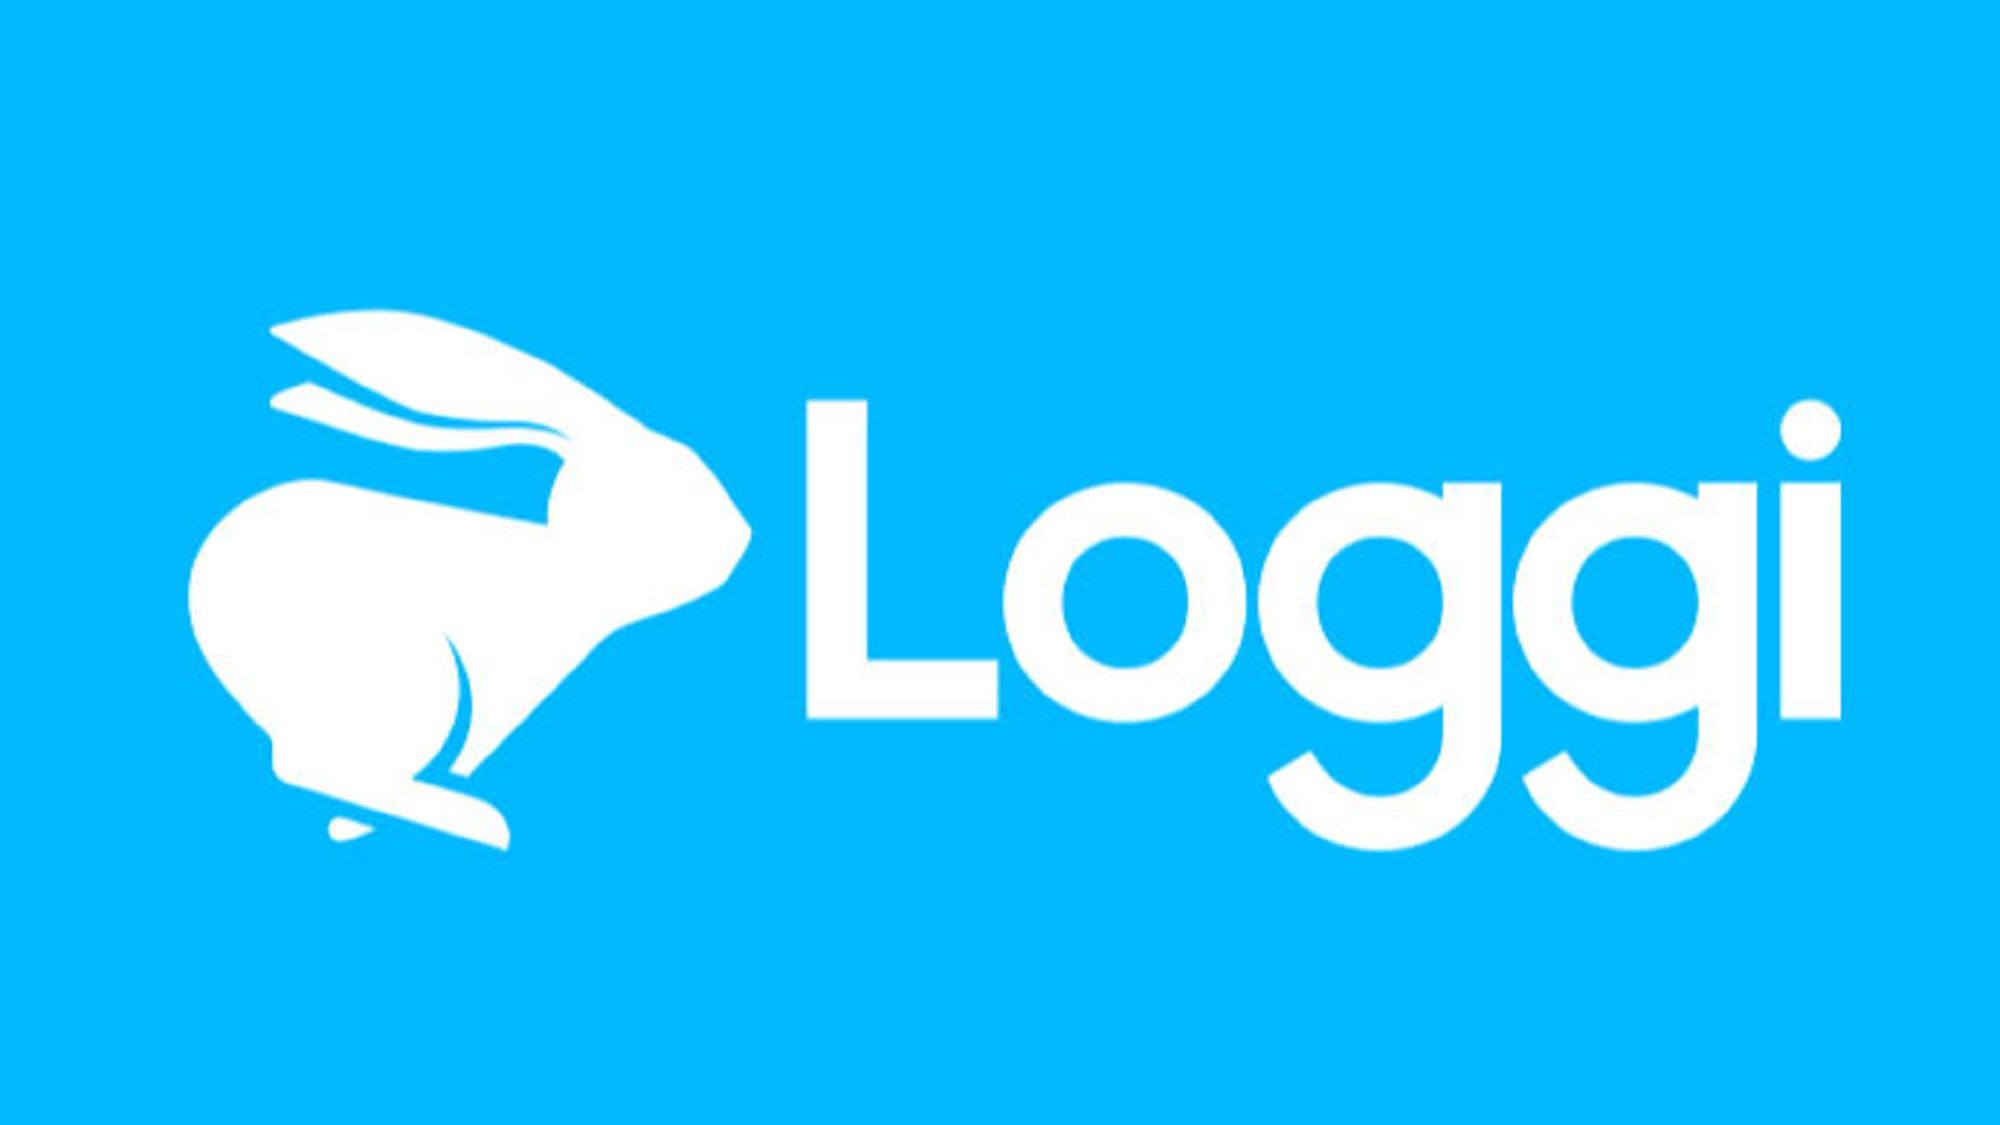

## 2\. Pacotes e bibliotecas

In [ ]:
# importe todas as suas bibliotecas aqui, siga os padrões do PEP8:
#
# - 1º pacotes nativos do python: json, os, etc.;
# - 2º pacotes de terceiros: pandas, seabornm etc.;
# - 3º pacotes que você desenvolveu.
!pip install geopandas
import json


import pandas as pd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import numpy as np
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns

## 3\. Exploração de dados

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv


In [ ]:
#Pegando o arquivo
deliveries_df = pd.read_json('deliveries.json')

#Normalizando o json
hub_origin = pd.json_normalize(deliveries_df['origin'])

#Juntando as colunas
deliveries_df = pd.merge(left=deliveries_df,right=hub_origin,how='inner', left_index=True, right_index=True)

#Retirando as colunas
deliveries_df = deliveries_df.drop(columns=['origin'], axis=1)

#Reposicionando as colunas
deliveries_df = deliveries_df[['name','region', 'lng', 'lat','vehicle_capacity','deliveries']]

#Renomeando as colunas
deliveries_df = deliveries_df.rename(columns={'lng':'hub_lng', 'lat':'hub_lat'})

#Usando o explode
deli_explode_df = deliveries_df[["deliveries"]].explode('deliveries')


In [ ]:
#Estrurando os dados para utilização
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deli_explode_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deli_explode_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deli_explode_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


In [ ]:
#Tirando a coluna de deliveries antiga
deliveries_df = deliveries_df.drop(columns=['deliveries'], axis=1)

#Juntando as colunas novas com as antigas
deliveries_df = pd.merge(left=deliveries_df,right=deliveries_normalized_df,how='right', left_index=True, right_index=True)

#Resetando o index
deliveries_df.reset_index(inplace=True, drop=True)

#Mostrando o dado
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


In [ ]:
#Vendo a estrutura dos dados
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


In [ ]:
#Vendo medias e etc
deliveries_df.drop(['name','region'],axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


In [ ]:
#Verificando os nulos
deliveries_df.isnull().sum()

name                0
region              0
hub_lng             0
hub_lat             0
vehicle_capacity    0
delivery_size       0
delivery_lng        0
delivery_lat        0
dtype: int64

## 4\. Manipulação

In [ ]:
#Pegando a latitude dos hub
hub_df = deliveries_df[['hub_lng','hub_lat','region']]
hub_df = hub_df.drop_duplicates().sort_values(by='region').reset_index(drop=True)
hub_df.head()


,hub_lng,hub_lat,region
0,-47.802665,-15.657014,df-0
1,-47.893662,-15.805118,df-1
2,-48.054989,-15.838145,df-2


In [ ]:
geolocator = Nominatim(user_agent="julio_ebac")
# Cria um objeto geocoder que limita a taxa de chamadas à função geolocator.reverse
# Define um atraso mínimo de 1 segundo entre as chamadas para evitar sobrecarga no serviço
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [ ]:
# Combinando as colunas de lng e lat
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
# Localiza os locais e coloca na coluna "geodata"
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
# Exibe o hub
hub_df.head()

,hub_lng,hub_lat,region,coordinates,geodata
0,-47.802665,-15.657014,df-0,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,-47.893662,-15.805118,df-1,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,-48.054989,-15.838145,df-2,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [ ]:
# Normalizei os dados e criei um novo DATAFRAME
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda x: x.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.053343,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-127,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172753950067,-47.89372354453109,highway,residential,26,0.053411,...,Distrito Federal,BR-DF,Região Centro-Oeste,70336-000,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000010,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [ ]:
# Seleciona as colunas e trata as que estão nulos
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]

hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)

hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])

hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])

hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)

hub_geodata_df.head()

<ipython-input-204-1c937c061925>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
<ipython-input-204-1c937c061925>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
<ipython-input-204-1c937c061925>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [ ]:
hub_df = pd.merge(hub_df, hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[['region','hub_suburb','hub_city']]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [ ]:
# Juntando os DATAFRAME
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]

deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


In [ ]:
ARQUIVO_GEODATA = "deliveries-geodata.csv"
deliveries_geodata_df = pd.read_csv(ARQUIVO_GEODATA)
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()


,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
#Qualidade sobre o dado
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


In [ ]:
#Qualidade sobre os dados
deliveries_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hub_lng,636149.0,-47.949902,0.091875,-48.054989,-48.054989,-47.893662,-47.893662,-47.802665
hub_lat,636149.0,-15.802359,0.053463,-15.838145,-15.838145,-15.805118,-15.805118,-15.657014
vehicle_capacity,636149.0,180.000000,0.000000,180.000000,180.000000,180.000000,180.000000,180.000000
delivery_size,636149.0,5.512111,2.874557,1.000000,3.000000,6.000000,8.000000,10.000000
delivery_lng,636149.0,-47.946087,0.112769,-48.280779,-48.035911,-47.928967,-47.883394,-47.310611
delivery_lat,636149.0,-15.809492,0.082462,-16.050028,-15.842795,-15.814033,-15.769516,-15.500355


In [ ]:
#Qualidade sobre os dados
deliveries_df.isnull().sum()

name                     0
region                   0
hub_lng                  0
hub_lat                  0
hub_city                 0
hub_suburb               0
vehicle_capacity         0
delivery_size            0
delivery_lng             0
delivery_lat             0
delivery_city         1702
delivery_suburb     159885
dtype: int64

## 5\. Visualização

In [ ]:
#Pegando o arquivo
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

replace ./maps/ASB_Cemiterio_A.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
#Criando o mapa
mapa = geopandas.read_file('./distrito-federal.shp')
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [ ]:
# Criando as localizações dos hubs
hub_df = deliveries_df[['region','hub_lng','hub_lat']]
hub_df = hub_df.drop_duplicates().sort_values(by='region').reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df['hub_lng'], hub_df['hub_lat']))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)


In [ ]:
# Criando as localizações dos deliveries
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df['delivery_lng'], deliveries_df['delivery_lat']))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


<ipython-input-217-49f60a702dff>:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


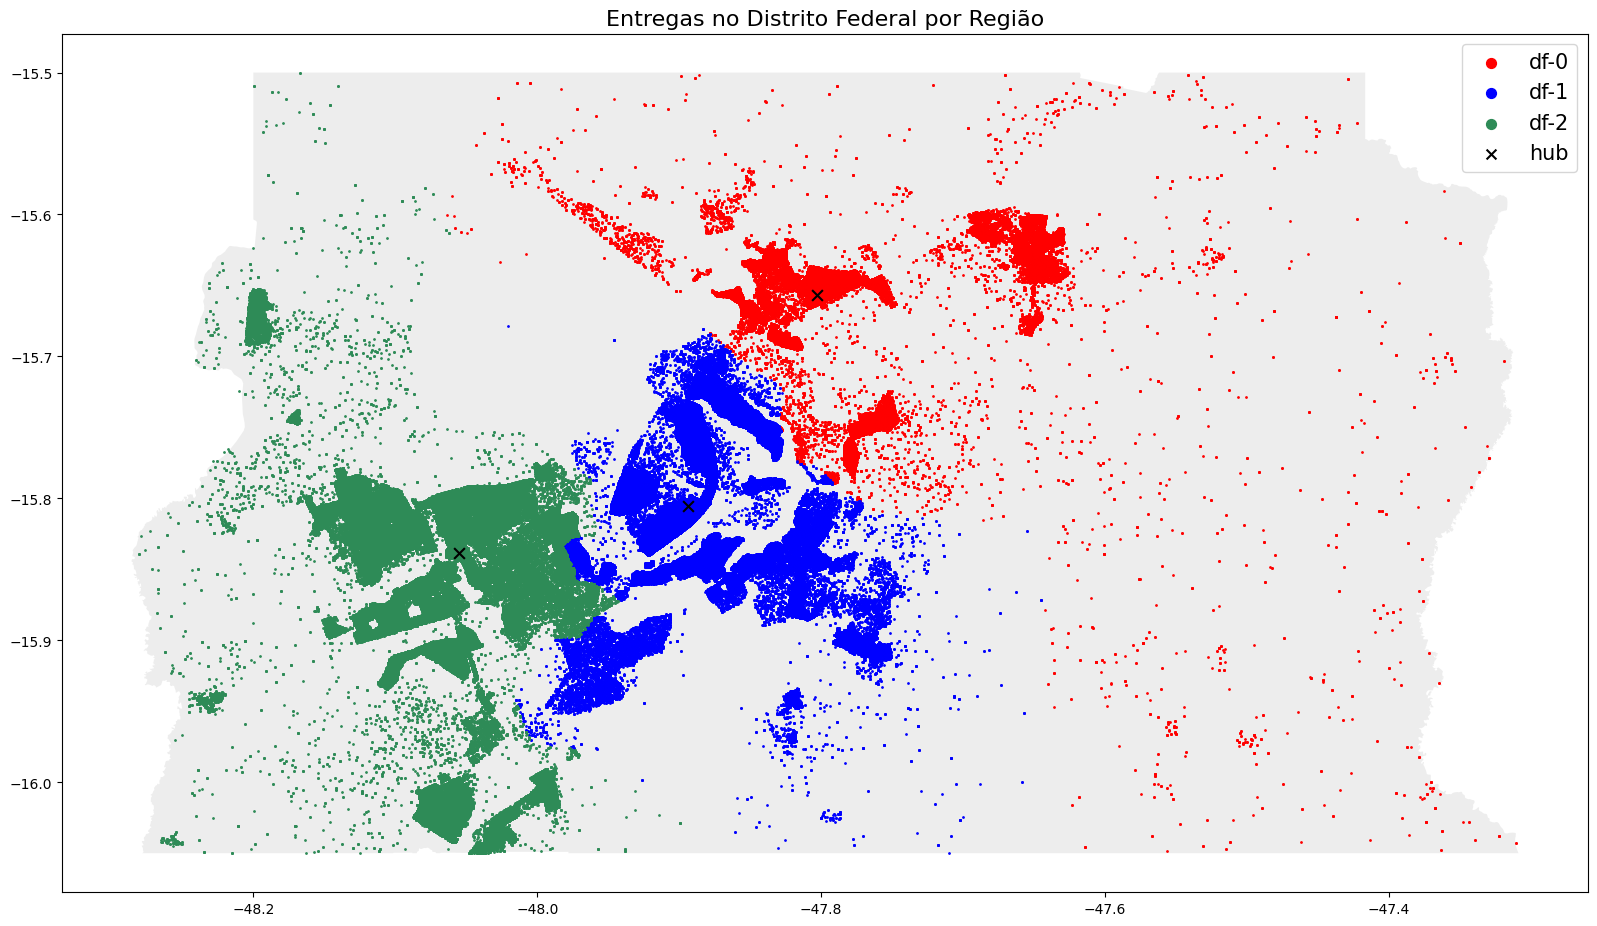

In [ ]:
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=60, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

In [ ]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.head()

,region,vehicle_capacity,proportion
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


<ipython-input-219-4e5092e1fa1e>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="proportion", ci=None, palette="pastel")
<ipython-input-219-4e5092e1fa1e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="proportion", ci=None, palette="pastel")


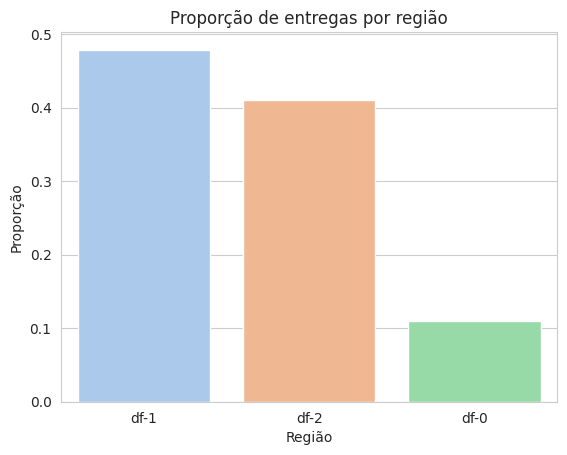

In [ ]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="proportion", ci=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

- Vemos que o df-1 e df-2 sao as regiões com mais entregas, sendo assim poderia ter um jeito de ajudar eles a aumentar a velocidade das entregas. Sabendo que todos os veiculos tem os mesmos pesos, talvez colocar uma maior quantia de veiculos na df-1 faça as entregas terem maior qualidade.